# SUJAY ENCODING

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import statistics
import category_encoders as ce

In [2]:
# Reading file
trial1 = pd.read_csv(r'E:/DPA Project/cleanedDataForModelling.csv')
trial1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446992 entries, 0 to 446991
Data columns (total 19 columns):
id              446992 non-null int64
url             446992 non-null object
region          446992 non-null object
price           446992 non-null int64
year            446992 non-null float64
manufacturer    446992 non-null object
model           446992 non-null object
condition       446992 non-null object
cylinders       446992 non-null int64
fuel            446992 non-null object
odometer        446992 non-null float64
title_status    446992 non-null object
transmission    446992 non-null object
drive           446992 non-null int64
type            446992 non-null object
paint_color     446992 non-null object
state           446992 non-null object
lat             446992 non-null float64
long            446992 non-null float64
dtypes: float64(4), int64(4), object(11)
memory usage: 64.8+ MB


In [3]:
# Removing columns which will not be contributing to any of our models.
dropColumns = ['id','url', 'region', 'model', 'paint_color', 'state', 'lat','long']
trial1 = trial1.drop(columns = dropColumns)

trial1.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type
0,17899,2012.0,volkswagen,excellent,4,gas,63500.0,clean,manual,4,hatchback
1,46463,2015.0,gmc,excellent,6,gas,7554.0,clean,automatic,4,truck
2,49999,2018.0,ford,like new,6,diesel,70150.0,clean,automatic,4,pickup
3,13999,2009.0,ram,good,6,gas,120057.0,clean,automatic,4,pickup
4,34500,2017.0,ford,excellent,6,diesel,95484.0,clean,automatic,4,pickup


In [4]:
# Checking null values
print(trial1.isnull().sum())

price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
dtype: int64


In [5]:
trial1.info()
#trial1.manufacturer.value_counts().sort_values(ascending=False)
trial1.transmission.value_counts()

trial1.groupby(['manufacturer']).describe()['price']
#trial1[(trial1.transmission=="type")]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446992 entries, 0 to 446991
Data columns (total 11 columns):
price           446992 non-null int64
year            446992 non-null float64
manufacturer    446992 non-null object
condition       446992 non-null object
cylinders       446992 non-null int64
fuel            446992 non-null object
odometer        446992 non-null float64
title_status    446992 non-null object
transmission    446992 non-null object
drive           446992 non-null int64
type            446992 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 37.5+ MB


,count,mean,std,min,25%,50%,75%,max
manufacturer,,,,,,,,
acura,3668.0,9867.636041,8988.556622,750.0,4399.75,7900.0,12991.00,144888.0
alfa-romeo,78.0,21546.102564,12853.776949,1800.0,9992.50,22995.0,27421.00,68875.0
aston-martin,20.0,59519.650000,25246.588998,22900.0,46864.50,53947.5,65000.00,119888.0
audi,4949.0,14810.582542,10862.477173,750.0,7000.00,12995.0,19483.00,124977.0
bmw,12185.0,13906.431596,10472.451299,750.0,6444.00,11495.0,18999.00,139995.0
buick,5497.0,9625.298345,6896.028857,750.0,3950.00,8088.0,14500.00,125000.0
cadillac,6510.0,13493.650384,11150.725553,750.0,5495.00,10263.5,17995.00,79995.0
chevrolet,64857.0,14543.018163,11262.196624,750.0,5950.00,11950.0,19995.00,149980.0
chrysler,7788.0,8401.961222,6744.733802,750.0,3500.00,6450.0,11495.00,64000.0


In [6]:
# Encoding "manufacturer" feature
# trial1 = pd.concat([ce.BinaryEncoder(cols=['manufacturer']).fit_transform(trial1)],axis=1)
top_10 = trial1.manufacturer.value_counts(ascending=False).head(11)
top_10_names = [x for x in top_10.index]
top_10_names.pop(-3)
top_10_names

premium = ['acura','alfa-romeo','aston-martin','audi', 'bmw','cadillac', 'ferrari','gmc','harley-davidson','hennessey','jeep','lexus','lincoln','mercedes-benz','morgan','ram','tesla']

for label in top_10_names:
    trial1[label] = np.where(trial1['manufacturer']==label,1,0)

trial1['premium'] = trial1['manufacturer'].apply(lambda x:1 if (x in premium) else 0)
trial1.head(20)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,...,chevrolet,toyota,ram,honda,nissan,jeep,gmc,dodge,bmw,premium
0,17899,2012.0,volkswagen,excellent,4,gas,63500.0,clean,manual,4,...,0,0,0,0,0,0,0,0,0,0
1,46463,2015.0,gmc,excellent,6,gas,7554.0,clean,automatic,4,...,0,0,0,0,0,0,1,0,0,1
2,49999,2018.0,ford,like new,6,diesel,70150.0,clean,automatic,4,...,0,0,0,0,0,0,0,0,0,0
3,13999,2009.0,ram,good,6,gas,120057.0,clean,automatic,4,...,0,0,1,0,0,0,0,0,0,1
4,34500,2017.0,ford,excellent,6,diesel,95484.0,clean,automatic,4,...,0,0,0,0,0,0,0,0,0,0
5,14500,2007.0,gmc,excellent,6,gas,89340.0,clean,automatic,4,...,0,0,0,0,0,0,1,0,0,1
6,12500,2013.0,ford,fair,6,gas,226031.0,clean,automatic,4,...,0,0,0,0,0,0,0,0,0,0
7,34500,2012.0,ram,salvage,6,diesel,128153.0,clean,automatic,4,...,0,0,1,0,0,0,0,0,0,1
8,5900,1994.0,ford,salvage,6,gas,168838.0,clean,manual,4,...,0,0,0,0,0,0,0,0,0,0
9,16500,2013.0,gmc,salvage,6,other,156385.0,clean,automatic,4,...,0,0,0,0,0,0,1,0,0,1


In [7]:
# Encoding "condition" feature
trial1['condition'] = trial1['condition'].map({'salvage': 0, 'fair': 1, 'good': 2, 'excellent': 3, 'like new': 4, 'new': 5})

# Encoding "fuel" feature
trial1['fuel'] = trial1['fuel'].map({'gas': 0, 'hybrid': 1, 'diesel': 2, 'electric': 3, 'other': 4})

# Encoding "title_status" feature
trial1 = pd.get_dummies(trial1, prefix=['title'], columns = ['title_status'], drop_first=True)

# Encoding "transmission" feature
trial1['transmission'] = trial1['transmission'].map({'manual': 0, 'automatic': 1, 'other': 2})

# Encoding "type" feature
trial1['type'] = trial1['type'].map({'mini-van': 0, 'hatchback': 1, 'wagon': 2, 'sedan': 3, 'van': 4, 'SUV': 5, 'convertible': 6, 'coupe': 7,'offroad': 8, 'other':9, 'truck':10, 'pickup':11, 'bus':12})

trial1.head()

#for cols in categoricalCols:
#    if cols in trial1.columns:
#        le = LabelEncoder()
#        train0[[col]] = train0[[col]].apply(le.fit_transform)

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,...,jeep,gmc,dodge,bmw,premium,title_lien,title_missing,title_parts only,title_rebuilt,title_salvage
0,17899,2012.0,volkswagen,3,4,0,63500.0,0,4,1,...,0,0,0,0,0,0,0,0,0,0
1,46463,2015.0,gmc,3,6,0,7554.0,1,4,10,...,0,1,0,0,1,0,0,0,0,0
2,49999,2018.0,ford,4,6,2,70150.0,1,4,11,...,0,0,0,0,0,0,0,0,0,0
3,13999,2009.0,ram,2,6,0,120057.0,1,4,11,...,0,0,0,0,1,0,0,0,0,0
4,34500,2017.0,ford,3,6,2,95484.0,1,4,11,...,0,0,0,0,0,0,0,0,0,0


In [8]:
trial1 = trial1.drop(columns = 'manufacturer')
trial1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446992 entries, 0 to 446991
Data columns (total 25 columns):
price               446992 non-null int64
year                446992 non-null float64
condition           446992 non-null int64
cylinders           446992 non-null int64
fuel                446992 non-null int64
odometer            446992 non-null float64
transmission        446992 non-null int64
drive               446992 non-null int64
type                446992 non-null int64
ford                446992 non-null int32
chevrolet           446992 non-null int32
toyota              446992 non-null int32
ram                 446992 non-null int32
honda               446992 non-null int32
nissan              446992 non-null int32
jeep                446992 non-null int32
gmc                 446992 non-null int32
dodge               446992 non-null int32
bmw                 446992 non-null int32
premium             446992 non-null int64
title_lien          446992 non-null uint8
tit

# SUKESH

# Modelling

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
#import pandas_profiling as pp

# models
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#import xgboost as xgb
#import lightgbm as lgb

# model tuning
#from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

In [4]:
valid_part = 0.3
pd.set_option('max_columns',100)

In [6]:
train0 = pd.read_csv(r'E:/DPA Project/updatedcleanedvehicles.csv')

train0.head()

,id,url,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,17899,2012.0,volkswagen,golf r,excellent,4,gas,63500.0,clean,manual,4,hatchback,black,ut,40.760779,-111.891047
1,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,46463,2015.0,gmc,sierra 1500,excellent,6,gas,7554.0,clean,automatic,4,truck,white,ut,40.760779,-111.891047
2,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,49999,2018.0,ford,f-450,like new,6,diesel,70150.0,clean,automatic,4,pickup,white,ut,40.760779,-111.891047
3,7034406582,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,13999,2009.0,ram,unknown,good,6,gas,120057.0,clean,automatic,4,pickup,silver,ut,40.760779,-111.891047
4,7034405619,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,34500,2017.0,ford,f-350,excellent,6,diesel,95484.0,clean,automatic,4,pickup,white,ut,40.760779,-111.891047


In [9]:
train0.title_status.value_counts()

clean         446665
rebuilt        10387
salvage         5297
lien            2841
missing          590
parts only       218
Name: title_status, dtype: int64

In [5]:
#train0 = pd.read_csv(r'D:/Projects/DPA/Used-Cars-Analysis/data/vehicles_1.csv')

#train0.head()

In [10]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465998 entries, 0 to 465997
Data columns (total 19 columns):
id              465998 non-null int64
url             465998 non-null object
region          465998 non-null object
price           465998 non-null int64
year            465998 non-null float64
manufacturer    465998 non-null object
model           465998 non-null object
condition       465998 non-null object
cylinders       465998 non-null int64
fuel            465998 non-null object
odometer        465998 non-null float64
title_status    465998 non-null object
transmission    465998 non-null object
drive           465998 non-null int64
type            465998 non-null object
paint_color     465998 non-null object
state           465998 non-null object
lat             465998 non-null float64
long            465998 non-null float64
dtypes: float64(4), int64(4), object(11)
memory usage: 67.6+ MB


In [11]:
drop_columns = ['id','url', 'region', 'model', 'state', 'lat','long']
train0 = train0.drop(columns = drop_columns)

In [8]:
null_values=train0.isnull().sum()
null_values=pd.DataFrame(null_values,columns=['null'])
j=1
sum_tot=len(train0)
null_values['percent']=null_values['null']/sum_tot
round(null_values*100,3).sort_values('percent',ascending=False)

,null,percent
price,0,0.0
year,0,0.0
manufacturer,0,0.0
condition,0,0.0
cylinders,0,0.0
fuel,0,0.0
odometer,0,0.0
transmission,0,0.0
drive,0,0.0
type,0,0.0


In [12]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465998 entries, 0 to 465997
Data columns (total 12 columns):
price           465998 non-null int64
year            465998 non-null float64
manufacturer    465998 non-null object
condition       465998 non-null object
cylinders       465998 non-null int64
fuel            465998 non-null object
odometer        465998 non-null float64
title_status    465998 non-null object
transmission    465998 non-null object
drive           465998 non-null int64
type            465998 non-null object
paint_color     465998 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 42.7+ MB


In [18]:
# Encoding the categorical features
categorical_columns = train0.select_dtypes(exclude=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

for col in categorical_columns:
    if col in train0.columns:
        le = LabelEncoder()
        train0[[col]] = train0[[col]].apply(le.fit_transform)

In [19]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465998 entries, 0 to 465997
Data columns (total 12 columns):
price           465998 non-null int64
year            465998 non-null float16
manufacturer    465998 non-null int32
condition       465998 non-null int32
cylinders       465998 non-null int8
fuel            465998 non-null int32
odometer        465998 non-null float32
title_status    465998 non-null int32
transmission    465998 non-null int32
drive           465998 non-null int8
type            465998 non-null int32
paint_color     465998 non-null int32
dtypes: float16(1), float32(1), int32(7), int64(1), int8(2)
memory usage: 19.6 MB


In [11]:
# Thanks to : https://www.kaggle.com/aantonova/some-new-risk-and-clusters-features
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [21]:
train0 = reduce_mem_usage(train0)

Mem. usage decreased to 10.22 Mb (47.7% reduction)


In [22]:
train0.corr()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
price,1.000000,-0.004102,0.003135,-0.002732,-0.000621,0.000329,-0.001053,-0.000959,0.003235,0.000276,-0.000207,-0.000024
year,-0.004102,1.000000,0.004431,-0.002662,-0.144102,0.038335,-0.226688,0.014238,-0.101696,0.025720,-0.019095,-0.011465
manufacturer,0.003135,0.004431,1.000000,0.006940,-0.184735,-0.056092,0.006768,0.015469,0.069180,0.012601,0.032957,0.004317
condition,-0.002732,-0.002662,0.006940,1.000000,-0.004740,0.013957,-0.016480,-0.001956,0.012869,0.116344,0.089462,0.098930
cylinders,-0.000621,-0.144102,-0.184735,-0.004740,1.000000,-0.093609,0.064717,-0.067362,-0.025315,0.216314,0.066822,0.033229
fuel,0.000329,0.038335,-0.056092,0.013957,-0.093609,1.000000,-0.089631,0.009888,0.021274,-0.103656,-0.126553,-0.050877
odometer,-0.001053,-0.226688,0.006768,-0.016480,0.064717,-0.089631,1.000000,-0.026939,-0.023467,0.032304,0.028247,0.017576
title_status,-0.000959,0.014238,0.015469,-0.001956,-0.067362,0.009888,-0.026939,1.000000,-0.006866,-0.015710,0.013757,-0.011238
transmission,0.003235,-0.101696,0.069180,0.012869,-0.025315,0.021274,-0.023467,-0.006866,1.000000,-0.024569,-0.006183,-0.016783
drive,0.000276,0.025720,0.012601,0.116344,0.216314,-0.103656,0.032304,-0.015710,-0.024569,1.000000,-0.016955,0.089336


In [15]:
#train0 = train0[train0['price'] > 1000]
#train0 = train0[train0['price'] < 40000]
# Rounded ['odometer'] to 5000
#train0['odometer'] = train0['odometer'] // 5000
#train0 = train0[train0['year'] > 110]

In [23]:
train0.corr()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
price,1.000000,-0.004102,0.003135,-0.002732,-0.000621,0.000329,-0.001053,-0.000959,0.003235,0.000276,-0.000207,-0.000024
year,-0.004102,1.000000,0.004431,-0.002662,-0.144102,0.038335,-0.226688,0.014238,-0.101696,0.025720,-0.019095,-0.011465
manufacturer,0.003135,0.004431,1.000000,0.006940,-0.184735,-0.056092,0.006768,0.015469,0.069180,0.012601,0.032957,0.004317
condition,-0.002732,-0.002662,0.006940,1.000000,-0.004740,0.013957,-0.016480,-0.001956,0.012869,0.116344,0.089462,0.098930
cylinders,-0.000621,-0.144102,-0.184735,-0.004740,1.000000,-0.093609,0.064717,-0.067362,-0.025315,0.216314,0.066822,0.033229
fuel,0.000329,0.038335,-0.056092,0.013957,-0.093609,1.000000,-0.089631,0.009888,0.021274,-0.103656,-0.126553,-0.050877
odometer,-0.001053,-0.226688,0.006768,-0.016480,0.064717,-0.089631,1.000000,-0.026939,-0.023467,0.032304,0.028247,0.017576
title_status,-0.000959,0.014238,0.015469,-0.001956,-0.067362,0.009888,-0.026939,1.000000,-0.006866,-0.015710,0.013757,-0.011238
transmission,0.003235,-0.101696,0.069180,0.012869,-0.025315,0.021274,-0.023467,-0.006866,1.000000,-0.024569,-0.006183,-0.016783
drive,0.000276,0.025720,0.012601,0.116344,0.216314,-0.103656,0.032304,-0.015710,-0.024569,1.000000,-0.016955,0.089336


### Preparaing to the Modelling

In [25]:
y = train0['price']
X = train0.drop('price',axis=1)

#y = sample['price']
#X = sample.drop('price',axis=1)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(340887, 10) (340887,)
(85222, 10) (85222,)


In [26]:
train, test, target, target_test = train_test_split(X, y, test_size=valid_part, random_state=0)

#### Min-max scaler:


#### For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

In [123]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()   
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)

C:\Users\sukes\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int8, float16, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [124]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()   
X_train= sc.fit_transform(train)
X_test= sc.transform(test)

C:\Users\sukes\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int8, float16, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [29]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [30]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [31]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', y_train[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(y_train, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(y_train, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(y_train, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)
    
    #print('Accuracy for train',model.score(target, ytrain))


    print('target_test =', y_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(y_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(y_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(y_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)
    
    #print('Accuracy for test',model.score(target_test, ytest))


In [126]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(train, target)
acc_model(0,linreg,train,test)

target =  [13918 17500  3850  7900  6499]
ytrain =  [14143.5625 12858.4375 10713.5     8246.875   7355.1875]
acc(r2_score) for train = 33.88
acc(relative error) for train = 41.29
acc(rmse) for train = 676837.51
target_test = [ 2550 14500  9995  3300 11000]
ytest = [ 5876.25  10798.625 12661.625  9160.5   12097.125]
acc(r2_score) for test = 33.4
acc(relative error) for test = 41.23
acc(rmse) for test = 678641.51


In [ ]:
# Support Vector Machines
svr = SVR()
svr.fit(train, target)
acc_model(1,svr,train,test)

In [69]:
# Linear SVR

linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(1,linear_svr,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [22039.15438568 14233.52432095 16170.22938809 21654.14011425
 16329.64495431]
acc(r2_score) for train = -18.66
acc(relative error) for train = 46.91
acc(rmse) for train = 991329.31
target_test = [10997 15750  8995  4990 17940]
ytest = [16241.39845837 16325.2976051   7620.02717559  9428.38187242
 17195.11416565]
acc(r2_score) for test = -25.23
acc(relative error) for test = 46.91
acc(rmse) for test = 1019462.37


In [ ]:

mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(2,20)],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]}
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=10, verbose=True, pre_dispatch='2*n_jobs')
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test)

In [71]:
sgd = SGDRegressor()
sgd.fit(train, target)
acc_model(3,sgd,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [3.88674450e+14 3.35245157e+14 3.96019461e+14 4.11452768e+14
 3.54667318e+14]
acc(r2_score) for train = -1.7923075588900295e+23
acc(relative error) for train = 2964585502346.08
acc(rmse) for train = 3.852774956121168e+16
target_test = [10997 15750  8995  4990 17940]
ytest = [4.06185948e+14 3.97234799e+14 3.79723910e+14 3.31813377e+14
 3.93907651e+14]
acc(r2_score) for test = -1.7890815125737667e+23
acc(relative error) for test = 2962081921356.34
acc(rmse) for test = 3.8533247130159624e+16


In [70]:
random_forest = RandomForestRegressor()
random_forest.fit(train, target)
acc_model(2,random_forest,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [23676.19404762  7095.5        14410.525      27396.15
 21211.25332168]
acc(r2_score) for train = 94.38
acc(relative error) for train = 8.96
acc(rmse) for train = 215821.65
target_test = [10997 15750  8995  4990 17940]
ytest = [10672.3        20894.18666667  4024.5        14259.5
 17960.86666667]
acc(r2_score) for test = 83.22
acc(relative error) for test = 17.26
acc(rmse) for test = 373225.9


In [72]:
# Ridge Regressor
ridge = RidgeCV(cv=5)
ridge.fit(train, target)
acc_model(4,ridge,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [18613.57420012 10929.98096088 13784.54649812 18395.55827989
 19452.08767776]
acc(r2_score) for train = 34.77
acc(relative error) for train = 42.0
acc(rmse) for train = 735024.7
target_test = [10997 15750  8995  4990 17940]
ytest = [13042.82289309 14211.64427856  8417.13932353 13225.82138853
 14842.41622516]
acc(r2_score) for test = 34.23
acc(relative error) for test = 42.07
acc(rmse) for test = 738807.5


In [73]:
# Bagging Regressor

bagging = BaggingRegressor()
bagging.fit(train, target)
acc_model(5,bagging,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [24762.91666667  7025.4        14087.         23763.31166667
 21191.65768073]
acc(r2_score) for train = 94.38
acc(relative error) for train = 8.96
acc(rmse) for train = 215755.31
target_test = [10997 15750  8995  4990 17940]
ytest = [10447.3        20227.97333333  3793.5         4011.66666667
 17720.8       ]
acc(r2_score) for test = 83.35
acc(relative error) for test = 17.22
acc(rmse) for test = 371759.35


In [74]:
# Extra Trees Regressor

etr = ExtraTreesRegressor()
etr.fit(train, target)
acc_model(6,etr,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [23427.5         6995.         13998.         25996.5
 21243.83333333]
acc(r2_score) for train = 96.41
acc(relative error) for train = 4.37
acc(rmse) for train = 172462.25
target_test = [10997 15750  8995  4990 17940]
ytest = [10997.         20608.66666667  3729.5         6744.9
 17902.        ]
acc(r2_score) for test = 83.13
acc(relative error) for test = 16.4
acc(rmse) for test = 374186.07


In [75]:
# AdaBoost Regression

Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(train, target)
acc_model(7,Ada_Boost,train,test)

target =  [25900  6995 13998 32998 20900]
ytrain =  [24116.32310225 10454.44401615 11811.70091302 23300.73582184
 20779.54446295]
acc(r2_score) for train = 49.13
acc(relative error) for train = 42.05
acc(rmse) for train = 649054.08
target_test = [10997 15750  8995  4990 17940]
ytest = [13718.77889775 20284.44768243 10454.44401615 16702.48928605
 20779.54446295]
acc(r2_score) for test = 48.95
acc(relative error) for test = 42.13
acc(rmse) for test = 650931.91


In [76]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear SVR', 
              'Random Forest','Stochastic Gradient Decent',
                'RidgeRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 
              'AdaBoostRegressor', ],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })


In [90]:
models = models[models.Model != 'Stochastic Gradient Decent']

In [91]:
pd.options.display.float_format = '{:,.2f}'.format

In [92]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
5,BaggingRegressor,94.38,83.35,8.96,17.22,"215,755.31","371,759.35"
2,Random Forest,94.38,83.22,8.96,17.26,"215,821.65","373,225.90"
6,ExtraTreesRegressor,96.41,83.13,4.37,16.40,"172,462.25","374,186.07"
7,AdaBoostRegressor,49.13,48.95,42.05,42.13,"649,054.08","650,931.91"
0,Linear Regression,34.77,34.23,42.00,42.07,"735,025.24","738,808.09"
4,RidgeRegressor,34.77,34.23,42.00,42.07,"735,024.70","738,807.50"
1,Linear SVR,-18.66,-25.23,46.91,46.91,"991,329.31","1,019,462.37"


In [93]:
print('Prediction accuracy for models by relative error - d_test')
models.sort_values(by=['d_test', 'd_train'], ascending=True)

Prediction accuracy for models by relative error - d_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
6,ExtraTreesRegressor,96.41,83.13,4.37,16.40,"172,462.25","374,186.07"
5,BaggingRegressor,94.38,83.35,8.96,17.22,"215,755.31","371,759.35"
2,Random Forest,94.38,83.22,8.96,17.26,"215,821.65","373,225.90"
0,Linear Regression,34.77,34.23,42.00,42.07,"735,025.24","738,808.09"
4,RidgeRegressor,34.77,34.23,42.00,42.07,"735,024.70","738,807.50"
7,AdaBoostRegressor,49.13,48.95,42.05,42.13,"649,054.08","650,931.91"
1,Linear SVR,-18.66,-25.23,46.91,46.91,"991,329.31","1,019,462.37"


In [94]:
print('Prediction accuracy for models by RMSE - rmse_test')
models.sort_values(by=['rmse_test', 'rmse_train'], ascending=True)

Prediction accuracy for models by RMSE - rmse_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
5,BaggingRegressor,94.38,83.35,8.96,17.22,"215,755.31","371,759.35"
2,Random Forest,94.38,83.22,8.96,17.26,"215,821.65","373,225.90"
6,ExtraTreesRegressor,96.41,83.13,4.37,16.40,"172,462.25","374,186.07"
7,AdaBoostRegressor,49.13,48.95,42.05,42.13,"649,054.08","650,931.91"
4,RidgeRegressor,34.77,34.23,42.00,42.07,"735,024.70","738,807.50"
0,Linear Regression,34.77,34.23,42.00,42.07,"735,025.24","738,808.09"
1,Linear SVR,-18.66,-25.23,46.91,46.91,"991,329.31","1,019,462.37"


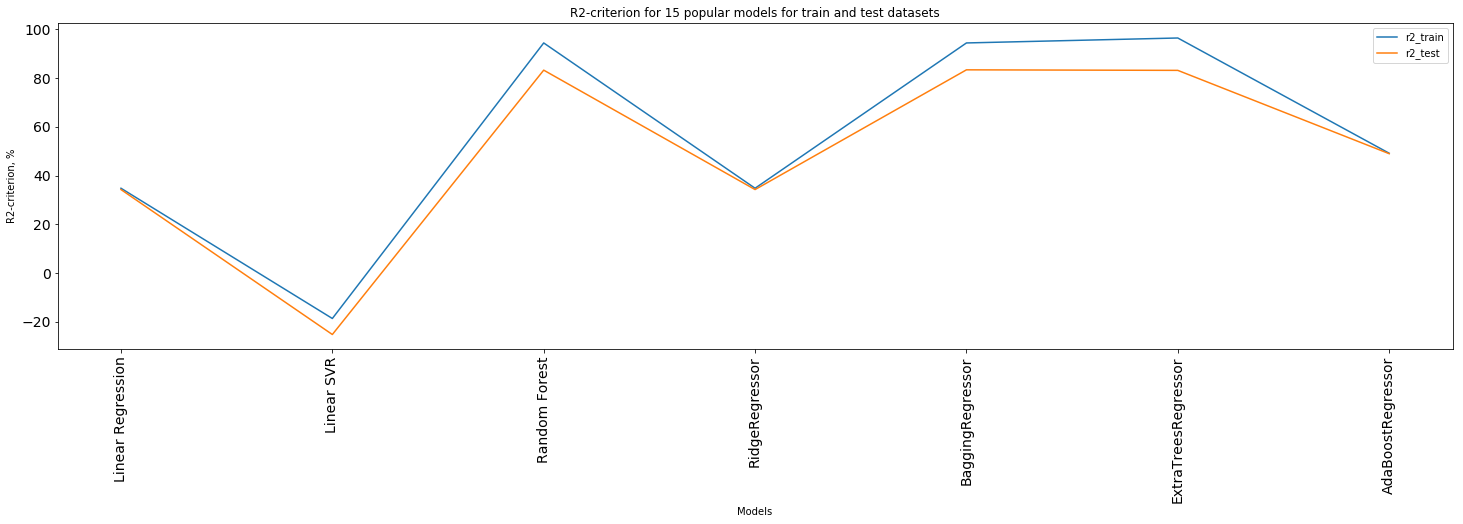

In [95]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2-criterion for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('R2-criterion, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

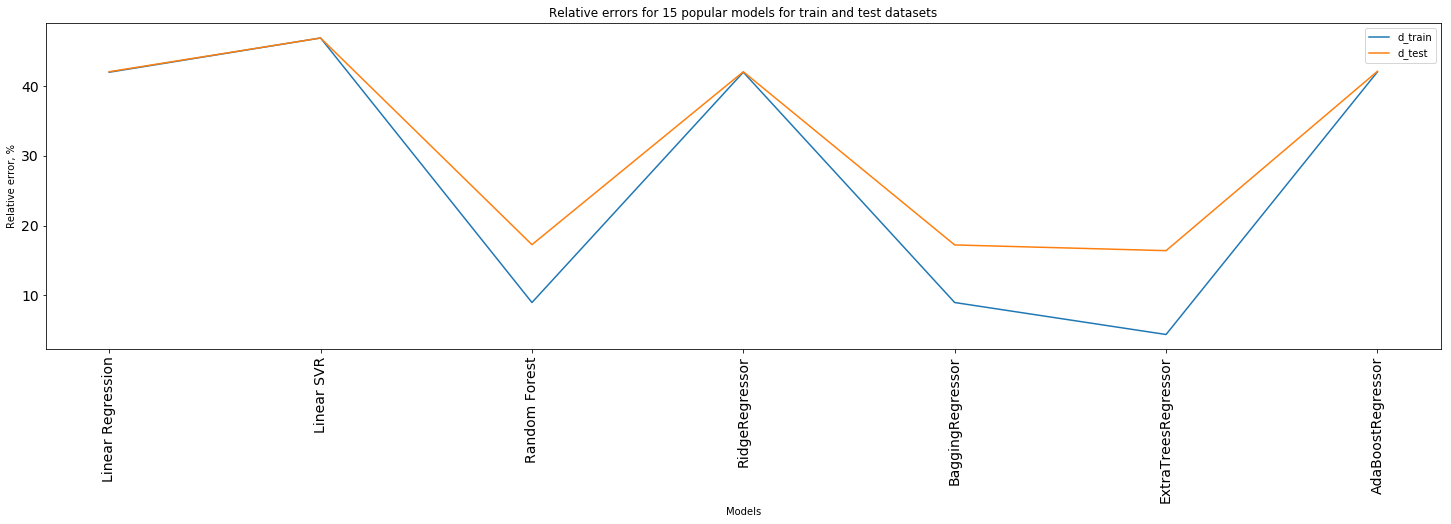

In [97]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

# SUJAY MODELING

In [9]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# Reducing memory usage
#trial1 = reduce_mem_usage(trial1)


### Preparaing to model

In [11]:
y = trial1['price']
X = trial1.drop('price',axis=1)
X.head()

,year,condition,cylinders,fuel,odometer,transmission,drive,type,ford,chevrolet,...,jeep,gmc,dodge,bmw,premium,title_lien,title_missing,title_parts only,title_rebuilt,title_salvage
0,2012.0,3,4,0,63500.0,0,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015.0,3,6,0,7554.0,1,4,10,0,0,...,0,1,0,0,1,0,0,0,0,0
2,2018.0,4,6,2,70150.0,1,4,11,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2009.0,2,6,0,120057.0,1,4,11,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2017.0,3,6,2,95484.0,1,4,11,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.head()

,year,condition,cylinders,fuel,odometer,transmission,drive,type,ford,chevrolet,...,jeep,gmc,dodge,bmw,premium,title_lien,title_missing,title_parts only,title_rebuilt,title_salvage
404545,2014.0,0,6,0,133875.000000,1,4,3,0,1,...,0,0,0,0,0,0,0,0,0,0
99507,1969.0,2,4,0,56030.000000,0,2,7,0,0,...,0,0,0,0,0,0,0,0,0,0
432713,2015.0,3,4,0,81000.000000,1,2,3,0,0,...,0,0,0,0,0,0,0,0,0,0
46203,2011.0,3,6,0,102669.000000,1,4,2,0,0,...,0,0,0,0,1,0,0,0,0,0
184746,2019.0,4,6,0,17193.923063,1,2,3,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(312894, 24) (312894,)
(134098, 24) (134098,)


In [14]:
#from sklearn.preprocessing import MinMaxScaler
#sc = MinMaxScaler()   
#X_train= sc.fit_transform(X_train)
#X_test= sc.fit_transform(X_test)

def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                                                                       
# applying normalize ( ) to all columns 
trial1 = trial1.apply(normalize) 

X_train.head()

,year,condition,cylinders,fuel,odometer,transmission,drive,type,ford,chevrolet,...,jeep,gmc,dodge,bmw,premium,title_lien,title_missing,title_parts only,title_rebuilt,title_salvage
404545,2014.0,0,6,0,133875.000000,1,4,3,0,1,...,0,0,0,0,0,0,0,0,0,0
99507,1969.0,2,4,0,56030.000000,0,2,7,0,0,...,0,0,0,0,0,0,0,0,0,0
432713,2015.0,3,4,0,81000.000000,1,2,3,0,0,...,0,0,0,0,0,0,0,0,0,0
46203,2011.0,3,6,0,102669.000000,1,4,2,0,0,...,0,0,0,0,1,0,0,0,0,0
184746,2019.0,4,6,0,17193.923063,1,2,3,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Multiple Linear Regression

mlm = LinearRegression()
mlm.fit(X_train, y_train)
y_pred = mlm.predict(X_test)

#acc_model(0,mlm,X_train,X_test)

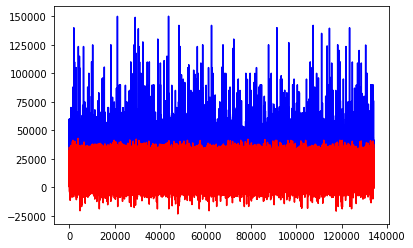

In [16]:
c = [i for i in range(1,134099,1)]
fig = plt.figure()
plt.plot(c,y_test,color="blue",linestyle="-")
plt.plot(c,y_pred,color="red",linestyle="-")


In [17]:
import statsmodels.api as sm

X_train_sm = X_train
X_train_sm = sm.add_constant(X_train_sm)
mlm1 = sm.OLS(y_train,X_train_sm).fit()
mlm1.params

C:\Users\sreeni\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const              -713487.391923
year                   356.918059
condition              832.615295
cylinders             1411.811316
fuel                  2320.153452
odometer                -0.080787
transmission         -2005.223280
drive                 1391.352516
type                   689.038913
ford                   819.844048
chevrolet              825.388506
toyota                2166.688524
ram                    599.332435
honda                  768.517182
nissan               -1816.216186
jeep                 -1205.201363
gmc                     73.243169
dodge                 -332.874674
bmw                  -1669.756621
premium               2635.614155
title_lien            2153.976607
title_missing        -1360.778884
title_parts only     -5253.045505
title_rebuilt        -3621.553900
title_salvage        -3661.967042
dtype: float64

In [18]:
mlm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                 1.504e+04
Date:                Sat, 11 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:19:08   Log-Likelihood:            -3.2444e+06
No. Observations:              312894   AIC:                         6.489e+06
Df Residuals:                  312869   BIC:                         6.489e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -7.135e+05   4364.869   -163.461      0.000   -7.22e+05   -7.05e+05
year               356.9181      2.170    164.479      0.000     352.665     361.171
condition          832.6153     13.538     61.502      0.000     806.081     859.149
cylinders         1411.8113     12.728    110.921      0.000    1386.865    1436.758
fuel              2320.1535     16.850    137.695      0.000    2287.128    2353.179
odometer            -0.0808      0.000   -256.464      0.000      -0.081      -0.080
transmission     -2005.2233     47.709    -42.030      0.000   -2098.733   -1911.714
drive             1391.3525     14.941     93.122      0.000    1362.068    1420.637
type               689.0389      5.108    134.897      0.000     679.028     699.050
ford               819.8440     47.198     17.370      0.000     727.337     912.351
chevrolet          825.3885     49.624     16.633      0.000     728.127     922.650
toyota            2166.6885     59.096     36.664      0.000    2050.862    2282.515
ram                599.3324     82.809      7.238      0.000     437.030     761.635
honda              768.5172     68.385     11.238      0.000     634.485     902.550
nissan           -1816.2162     68.543    -26.498      0.000   -1950.558   -1681.875
jeep             -1205.2014     81.169    -14.848      0.000   -1364.290   -1046.113
gmc                 73.2432     82.940      0.883      0.377     -89.316     235.802
dodge             -332.8747     79.305     -4.197      0.000    -488.310    -177.439
bmw              -1669.7566     96.676    -17.272      0.000   -1859.239   -1480.275
premium           2635.6142     58.624     44.958      0.000    2520.712    2750.516
title_lien        2153.9766    175.311     12.287      0.000    1810.372    2497.581
title_missing    -1360.7789    492.914     -2.761      0.006   -2326.876    -394.682
title_parts only -5253.0455    949.208     -5.534      0.000   -7113.467   -3392.624
title_rebuilt    -3621.5539     93.594    -38.694      0.000   -3804.995   -3438.113
title_salvage    -3661.9670    130.343    -28.095      0.000   -3917.435   -3406.499
==============================================================================
Omnibus:                   222217.663   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9966240.713
Skew:                           2.916   Prob(JB):                         0.00
Kurtosis:                      30.027   Cond. No.                     3.75e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+07. This might indicate that there are
strong multicollinearity or other numerical pr

In [19]:
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [20]:
# Calculating Vif value|
vif_cal(input_data=trial1, dependent_col="price")

,Var,Vif
0,year,25.63
5,transmission,11.85
2,cylinders,8.58
1,condition,7.02
6,drive,6.60
7,type,5.87
4,odometer,4.71
18,premium,4.52
8,ford,2.15
9,chevrolet,1.88


In [21]:
# Dropping highly correlated variables and insignificant variables
X_train = X_train.drop('year', 1)

# Create a second fitted model
mlm_2 = sm.OLS(y_train,X_train).fit()

print(mlm_2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.798
Method:                 Least Squares   F-statistic:                          5.384e+04
Date:                Sat, 11 Apr 2020   Prob (F-statistic):                        0.00
Time:                        16:19:30   Log-Likelihood:                     -3.2581e+06
No. Observations:              312894   AIC:                                  6.516e+06
Df Residuals:                  312871   BIC:                                  6.516e+06
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [22]:
# Calculating Vif value for the second time
vif_cal(input_data=trial1.drop(["year"], axis=1), dependent_col="price")

,Var,Vif
1,cylinders,8.57
4,transmission,8.43
5,drive,6.16
6,type,5.83
0,condition,4.65
17,premium,4.50
3,odometer,4.32
7,ford,2.13
8,chevrolet,1.87
10,ram,1.85


In [23]:
# Dropping highly correlated variables and insignificant variables
X_train = X_train.drop('transmission', 1)

# Create a second fitted model
mlm_3 = sm.OLS(y_train,X_train).fit()

print(mlm_3.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.798
Method:                 Least Squares   F-statistic:                          5.626e+04
Date:                Sat, 11 Apr 2020   Prob (F-statistic):                        0.00
Time:                        16:19:52   Log-Likelihood:                     -3.2582e+06
No. Observations:              312894   AIC:                                  6.516e+06
Df Residuals:                  312872   BIC:                                  6.517e+06
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [24]:
X_train.head()

,condition,cylinders,fuel,odometer,drive,type,ford,chevrolet,toyota,ram,...,jeep,gmc,dodge,bmw,premium,title_lien,title_missing,title_parts only,title_rebuilt,title_salvage
404545,0,6,0,133875.000000,4,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
99507,2,4,0,56030.000000,2,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
432713,3,4,0,81000.000000,2,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46203,3,6,0,102669.000000,4,2,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
184746,4,6,0,17193.923063,2,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Calculating Vif value for the third time
vif_cal(input_data=trial1.drop(["year","transmission"], axis=1), dependent_col="price")

,Var,Vif
1,cylinders,8.26
4,drive,5.95
5,type,5.81
16,premium,4.43
3,odometer,4.02
0,condition,3.89
6,ford,2.11
7,chevrolet,1.85
9,ram,1.84
13,gmc,1.65


In [26]:
# Adding  constant variable to test dataframe
X_test_model3 = sm.add_constant(X_test)

# Creating X_test_m6 dataframe by dropping variables from X_test_m6
X_test_model3 = X_test_model3.drop(["year","transmission",'const'], axis=1)

#

C:\Users\sreeni\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [27]:
X_test_model3.head()

,condition,cylinders,fuel,odometer,drive,type,ford,chevrolet,toyota,ram,...,jeep,gmc,dodge,bmw,premium,title_lien,title_missing,title_parts only,title_rebuilt,title_salvage
141244,2,6,0,154925.0,2,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217513,3,6,0,100160.0,2,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101326,2,8,0,65000.0,4,10,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
426808,3,6,0,82948.0,4,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
433314,4,6,0,117000.0,4,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Making predictions
y_pred_model3 = mlm_3.predict(X_test_model3)

In [29]:
# Calculating Vif value for the third time
# vif_cal(input_data=trial1.drop(["year","transmission","cylinders"], axis=1), dependent_col="price")

In [30]:
#acc_model(0,mlm_3,X_train,X_test_model3)

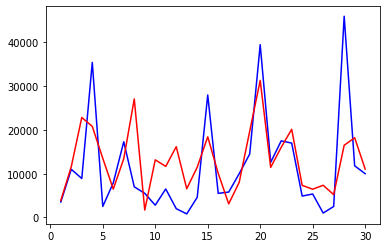

In [31]:
c = [i for i in range(1,31,1)]
fig = plt.figure()
plt.plot(c,y_test[0:30],color="blue",linestyle="-")
plt.plot(c,y_pred_model3[0:30],color="red",linestyle="-")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022902FA8438>]],
      dtype=object)

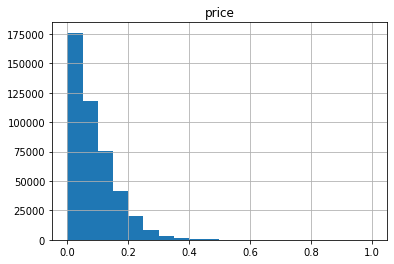

In [32]:
trial1.hist(column = "price" , bins = 20)

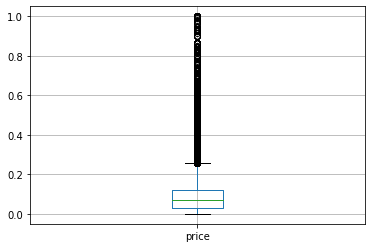

In [33]:
trial1.boxplot(column = "price")

# AJITH

# NAVYA

# MITHRA